# Check the GPU

In [1]:
!nvidia-smi

Tue Jun  9 10:59:03 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    11W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

# Import Libraries and Functions

In [2]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import os
import time
import datetime
import math
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(101)

# tensorflow imports
import tensorflow as tf
import tensorflow.keras.backend as K

# tf.keras imports
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Add, Softmax, GlobalMaxPool2D, DepthwiseConv2D
from tensorflow.keras.layers import BatchNormalization, MaxPooling2D, Input, ReLU, Lambda, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint
# Load the TensorBoard notebook extension
%load_ext tensorboard

# Clear any logs from previous runs
!rm -rf ./logs/ 

# Install Tensorboard profile plugin
!pip install -U tensorboard-plugin-profile

# Modified Batch Norm
!cp "/content/drive/My Drive/BatchNorm Research/Utils/MBatchNorm.py" .
from MBatchNorm import MBatchNorm

# Image Augmenters
from albumentations import (Compose, HorizontalFlip, Cutout, PadIfNeeded, RandomCrop)

# One Cycle LR
!cp "/content/drive/My Drive/BatchNorm Research/Utils/clr.py" .
from clr import *

Requirement already up-to-date: tensorboard-plugin-profile in /usr/local/lib/python3.6/dist-packages (2.2.0)


# Setting Hyperparams

In [0]:
# Dictionary of hyperparameters
hparams = {
    'learning_rate' : 0.4,  # fixed learning rate
    'batch_size': 32,  # training batch size
    'momentum' : 0.9, # fixed momentum
    'n_epochs': 2,  # number of epochs to train
    'decay' : 1e-04, # learning rate*batch size
}

# Data Preprocessing

## Downloading Dataset

In [0]:
zip_file = tf.keras.utils.get_file(origin="https://s3.amazonaws.com/fast-ai-imageclas/imagenette-320.tgz",
                                   fname="imagenette-320.tgz", extract=True)
base_dir, _ = os.path.splitext(zip_file)

In [0]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'val')

In [0]:
n_samples = sum([len(files) for r,d,files in os.walk(train_dir)])

## Image Augmentation techniques



In [51]:
image_size = 224 # All images will be resized to 224x224

def CustomImageDataGen(input_img):
    seq = Compose([PadIfNeeded(232,232, p=1),
                   RandomCrop(224,224, p=1),
                   HorizontalFlip(p=0.5),
                   Cutout(num_holes=1, max_h_size=56, max_w_size=56, p=0.5)
                  ], p=1)
    output_img = seq(image = input_img)['image']
    return output_img

# Rescale all images by 1./255 and apply image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                preprocessing_function=CustomImageDataGen)

validation_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 20 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
                train_dir,  # Source directory for the training images
                target_size=(image_size, image_size),
                batch_size=hparams['batch_size'],
                class_mode='categorical')

# Flow validation images in batches of 20 using test_datagen generator
validation_generator = validation_datagen.flow_from_directory(
                validation_dir, # Source directory for the validation images
                target_size=(image_size, image_size),
                batch_size=hparams['batch_size'],
                class_mode='categorical')

Found 12894 images belonging to 10 classes.
Found 500 images belonging to 10 classes.


# Resnet 50

In [0]:
# Copyright 2015 The TensorFlow Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================
# pylint: disable=invalid-name
"""ResNet models for Keras."""
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os

from tensorflow.python.keras import backend
from tensorflow.python.keras import layers
from tensorflow.python.keras.applications import imagenet_utils
from tensorflow.python.keras.engine import training
from tensorflow.python.keras.utils import data_utils
from tensorflow.python.keras.utils import layer_utils
from tensorflow.python.util.tf_export import keras_export


BASE_WEIGHTS_PATH = (
    'https://storage.googleapis.com/tensorflow/keras-applications/resnet/')
WEIGHTS_HASHES = {
    'resnet50': ('2cb95161c43110f7111970584f804107',
                 '4d473c1dd8becc155b73f8504c6f6626'),
    'resnet101': ('f1aeb4b969a6efcfb50fad2f0c20cfc5',
                  '88cf7a10940856eca736dc7b7e228a21'),
    'resnet152': ('100835be76be38e30d865e96f2aaae62',
                  'ee4c566cf9a93f14d82f913c2dc6dd0c'),
    'resnet50v2': ('3ef43a0b657b3be2300d5770ece849e0',
                   'fac2f116257151a9d068a22e544a4917'),
    'resnet101v2': ('6343647c601c52e1368623803854d971',
                    'c0ed64b8031c3730f411d2eb4eea35b5'),
    'resnet152v2': ('a49b44d1979771252814e80f8ec446f9',
                    'ed17cf2e0169df9d443503ef94b23b33'),
    'resnext50': ('67a5b30d522ed92f75a1f16eef299d1a',
                  '62527c363bdd9ec598bed41947b379fc'),
    'resnext101':
        ('34fb605428fcc7aa4d62f44404c11509', '0f678c91647380debd923963594981b3')
}


def ResNet(stack_fn,
           preact,
           use_bias,
           model_name='resnet',
           include_top=True,
           weights='imagenet',
           input_tensor=None,
           input_shape=None,
           pooling=None,
           classes=1000,
           classifier_activation='softmax',
           **kwargs):
  """Instantiates the ResNet, ResNetV2, and ResNeXt architecture.
  Optionally loads weights pre-trained on ImageNet.
  Note that the data format convention used by the model is
  the one specified in your Keras config at `~/.keras/keras.json`.
  Caution: Be sure to properly pre-process your inputs to the application.
  Please see `applications.resnet.preprocess_input` for an example.
  Arguments:
    stack_fn: a function that returns output tensor for the
      stacked residual blocks.
    preact: whether to use pre-activation or not
      (True for ResNetV2, False for ResNet and ResNeXt).
    use_bias: whether to use biases for convolutional layers or not
      (True for ResNet and ResNetV2, False for ResNeXt).
    model_name: string, model name.
    include_top: whether to include the fully-connected
      layer at the top of the network.
    weights: one of `None` (random initialization),
      'imagenet' (pre-training on ImageNet),
      or the path to the weights file to be loaded.
    input_tensor: optional Keras tensor
      (i.e. output of `layers.Input()`)
      to use as image input for the model.
    input_shape: optional shape tuple, only to be specified
      if `include_top` is False (otherwise the input shape
      has to be `(224, 224, 3)` (with `channels_last` data format)
      or `(3, 224, 224)` (with `channels_first` data format).
      It should have exactly 3 inputs channels.
    pooling: optional pooling mode for feature extraction
      when `include_top` is `False`.
      - `None` means that the output of the model will be
          the 4D tensor output of the
          last convolutional layer.
      - `avg` means that global average pooling
          will be applied to the output of the
          last convolutional layer, and thus
          the output of the model will be a 2D tensor.
      - `max` means that global max pooling will
          be applied.
    classes: optional number of classes to classify images
      into, only to be specified if `include_top` is True, and
      if no `weights` argument is specified.
    classifier_activation: A `str` or callable. The activation function to use
      on the "top" layer. Ignored unless `include_top=True`. Set
      `classifier_activation=None` to return the logits of the "top" layer.
    **kwargs: For backwards compatibility only.
  Returns:
    A `keras.Model` instance.
  Raises:
    ValueError: in case of invalid argument for `weights`,
      or invalid input shape.
    ValueError: if `classifier_activation` is not `softmax` or `None` when
      using a pretrained top layer.
  """
  if 'layers' in kwargs:
    global layers
    layers = kwargs.pop('layers')
  if kwargs:
    raise ValueError('Unknown argument(s): %s' % (kwargs,))
  if not (weights in {'imagenet', None} or os.path.exists(weights)):
    raise ValueError('The `weights` argument should be either '
                     '`None` (random initialization), `imagenet` '
                     '(pre-training on ImageNet), '
                     'or the path to the weights file to be loaded.')

  if weights == 'imagenet' and include_top and classes != 1000:
    raise ValueError('If using `weights` as `"imagenet"` with `include_top`'
                     ' as true, `classes` should be 1000')

  # Determine proper input shape
  input_shape = imagenet_utils.obtain_input_shape(
      input_shape,
      default_size=224,
      min_size=32,
      data_format=backend.image_data_format(),
      require_flatten=include_top,
      weights=weights)

  if input_tensor is None:
    img_input = layers.Input(shape=input_shape)
  else:
    if not backend.is_keras_tensor(input_tensor):
      img_input = layers.Input(tensor=input_tensor, shape=input_shape)
    else:
      img_input = input_tensor

  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  x = layers.ZeroPadding2D(
      padding=((3, 3), (3, 3)), name='conv1_pad')(img_input)
  x = layers.Conv2D(64, 7, strides=2, use_bias=use_bias, name='conv1_conv')(x)

  if not preact:
    x = MBatchNorm(
        axis=bn_axis, epsilon=1.001e-5, name='conv1_bn')(x)
    x = layers.Activation('relu', name='conv1_relu')(x)

  x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name='pool1_pad')(x)
  x = layers.MaxPooling2D(3, strides=2, name='pool1_pool')(x)

  x = stack_fn(x)

  if preact:
    x = MBatchNorm(
        axis=bn_axis, epsilon=1.001e-5, name='post_bn')(x)
    x = layers.Activation('relu', name='post_relu')(x)

  if include_top:
    x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    imagenet_utils.validate_activation(classifier_activation, weights)
    x = layers.Dense(classes, activation=classifier_activation,
                     name='predictions')(x)
  else:
    if pooling == 'avg':
      x = layers.GlobalAveragePooling2D(name='avg_pool')(x)
    elif pooling == 'max':
      x = layers.GlobalMaxPooling2D(name='max_pool')(x)

  # Ensure that the model takes into account
  # any potential predecessors of `input_tensor`.
  if input_tensor is not None:
    inputs = layer_utils.get_source_inputs(input_tensor)
  else:
    inputs = img_input

  # Create model.
  model = training.Model(inputs, x, name=model_name)

  # Load weights.
  if (weights == 'imagenet') and (model_name in WEIGHTS_HASHES):
    if include_top:
      file_name = model_name + '_weights_tf_dim_ordering_tf_kernels.h5'
      file_hash = WEIGHTS_HASHES[model_name][0]
    else:
      file_name = model_name + '_weights_tf_dim_ordering_tf_kernels_notop.h5'
      file_hash = WEIGHTS_HASHES[model_name][1]
    weights_path = data_utils.get_file(
        file_name,
        BASE_WEIGHTS_PATH + file_name,
        cache_subdir='models',
        file_hash=file_hash)
    model.load_weights(weights_path)
  elif weights is not None:
    model.load_weights(weights)

  return model


def block1(x, filters, kernel_size=3, stride=1, conv_shortcut=True, name=None):
  """A residual block.
  Arguments:
    x: input tensor.
    filters: integer, filters of the bottleneck layer.
    kernel_size: default 3, kernel size of the bottleneck layer.
    stride: default 1, stride of the first layer.
    conv_shortcut: default True, use convolution shortcut if True,
        otherwise identity shortcut.
    name: string, block label.
  Returns:
    Output tensor for the residual block.
  """
  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  if conv_shortcut:
    shortcut = layers.Conv2D(
        4 * filters, 1, strides=stride, name=name + '_0_conv')(x)
    shortcut = MBatchNorm(
        axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
  else:
    shortcut = x

  x = layers.Conv2D(filters, 1, strides=stride, name=name + '_1_conv')(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
  x = layers.Activation('relu', name=name + '_1_relu')(x)

  x = layers.Conv2D(
      filters, kernel_size, padding='SAME', name=name + '_2_conv')(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
  x = layers.Activation('relu', name=name + '_2_relu')(x)

  x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

  x = layers.Add(name=name + '_add')([shortcut, x])
  x = layers.Activation('relu', name=name + '_out')(x)
  return x


def stack1(x, filters, blocks, stride1=2, name=None):
  """A set of stacked residual blocks.
  Arguments:
    x: input tensor.
    filters: integer, filters of the bottleneck layer in a block.
    blocks: integer, blocks in the stacked blocks.
    stride1: default 2, stride of the first layer in the first block.
    name: string, stack label.
  Returns:
    Output tensor for the stacked blocks.
  """
  x = block1(x, filters, stride=stride1, name=name + '_block1')
  for i in range(2, blocks + 1):
    x = block1(x, filters, conv_shortcut=False, name=name + '_block' + str(i))
  return x


def block2(x, filters, kernel_size=3, stride=1, conv_shortcut=False, name=None):
  """A residual block.
  Arguments:
      x: input tensor.
      filters: integer, filters of the bottleneck layer.
      kernel_size: default 3, kernel size of the bottleneck layer.
      stride: default 1, stride of the first layer.
      conv_shortcut: default False, use convolution shortcut if True,
        otherwise identity shortcut.
      name: string, block label.
  Returns:
    Output tensor for the residual block.
  """
  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  preact = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_preact_bn')(x)
  preact = layers.Activation('relu', name=name + '_preact_relu')(preact)

  if conv_shortcut:
    shortcut = layers.Conv2D(
        4 * filters, 1, strides=stride, name=name + '_0_conv')(preact)
  else:
    shortcut = layers.MaxPooling2D(1, strides=stride)(x) if stride > 1 else x

  x = layers.Conv2D(
      filters, 1, strides=1, use_bias=False, name=name + '_1_conv')(preact)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
  x = layers.Activation('relu', name=name + '_1_relu')(x)

  x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
  x = layers.Conv2D(
      filters,
      kernel_size,
      strides=stride,
      use_bias=False,
      name=name + '_2_conv')(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
  x = layers.Activation('relu', name=name + '_2_relu')(x)

  x = layers.Conv2D(4 * filters, 1, name=name + '_3_conv')(x)
  x = layers.Add(name=name + '_out')([shortcut, x])
  return x


def stack2(x, filters, blocks, stride1=2, name=None):
  """A set of stacked residual blocks.
  Arguments:
      x: input tensor.
      filters: integer, filters of the bottleneck layer in a block.
      blocks: integer, blocks in the stacked blocks.
      stride1: default 2, stride of the first layer in the first block.
      name: string, stack label.
  Returns:
      Output tensor for the stacked blocks.
  """
  x = block2(x, filters, conv_shortcut=True, name=name + '_block1')
  for i in range(2, blocks):
    x = block2(x, filters, name=name + '_block' + str(i))
  x = block2(x, filters, stride=stride1, name=name + '_block' + str(blocks))
  return x


def block3(x,
           filters,
           kernel_size=3,
           stride=1,
           groups=32,
           conv_shortcut=True,
           name=None):
  """A residual block.
  Arguments:
    x: input tensor.
    filters: integer, filters of the bottleneck layer.
    kernel_size: default 3, kernel size of the bottleneck layer.
    stride: default 1, stride of the first layer.
    groups: default 32, group size for grouped convolution.
    conv_shortcut: default True, use convolution shortcut if True,
        otherwise identity shortcut.
    name: string, block label.
  Returns:
    Output tensor for the residual block.
  """
  bn_axis = 3 if backend.image_data_format() == 'channels_last' else 1

  if conv_shortcut:
    shortcut = layers.Conv2D(
        (64 // groups) * filters,
        1,
        strides=stride,
        use_bias=False,
        name=name + '_0_conv')(x)
    shortcut = MBatchNorm(
        axis=bn_axis, epsilon=1.001e-5, name=name + '_0_bn')(shortcut)
  else:
    shortcut = x

  x = layers.Conv2D(filters, 1, use_bias=False, name=name + '_1_conv')(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_1_bn')(x)
  x = layers.Activation('relu', name=name + '_1_relu')(x)

  c = filters // groups
  x = layers.ZeroPadding2D(padding=((1, 1), (1, 1)), name=name + '_2_pad')(x)
  x = layers.DepthwiseConv2D(
      kernel_size,
      strides=stride,
      depth_multiplier=c,
      use_bias=False,
      name=name + '_2_conv')(x)
  x_shape = backend.int_shape(x)[1:-1]
  x = layers.Reshape(x_shape + (groups, c, c))(x)
  x = layers.Lambda(
      lambda x: sum(x[:, :, :, :, i] for i in range(c)),
      name=name + '_2_reduce')(x)
  x = layers.Reshape(x_shape + (filters,))(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_2_bn')(x)
  x = layers.Activation('relu', name=name + '_2_relu')(x)

  x = layers.Conv2D(
      (64 // groups) * filters, 1, use_bias=False, name=name + '_3_conv')(x)
  x = MBatchNorm(
      axis=bn_axis, epsilon=1.001e-5, name=name + '_3_bn')(x)

  x = layers.Add(name=name + '_add')([shortcut, x])
  x = layers.Activation('relu', name=name + '_out')(x)
  return x


def stack3(x, filters, blocks, stride1=2, groups=32, name=None):
  """A set of stacked residual blocks.
  Arguments:
    x: input tensor.
    filters: integer, filters of the bottleneck layer in a block.
    blocks: integer, blocks in the stacked blocks.
    stride1: default 2, stride of the first layer in the first block.
    groups: default 32, group size for grouped convolution.
    name: string, stack label.
  Returns:
    Output tensor for the stacked blocks.
  """
  x = block3(x, filters, stride=stride1, groups=groups, name=name + '_block1')
  for i in range(2, blocks + 1):
    x = block3(
        x,
        filters,
        groups=groups,
        conv_shortcut=False,
        name=name + '_block' + str(i))
  return x


@keras_export('keras.applications.resnet50.ResNet50',
              'keras.applications.resnet.ResNet50',
              'keras.applications.ResNet50')
def ResNet50(include_top=True,
             weights='imagenet',
             input_tensor=None,
             input_shape=None,
             pooling=None,
             classes=1000,
             **kwargs):
  """Instantiates the ResNet50 architecture."""

  def stack_fn(x):
    x = stack1(x, 64, 3, stride1=1, name='conv2')
    x = stack1(x, 128, 4, name='conv3')
    x = stack1(x, 256, 6, name='conv4')
    return stack1(x, 512, 3, name='conv5')

  return ResNet(stack_fn, False, True, 'resnet50', include_top, weights,
                input_tensor, input_shape, pooling, classes, **kwargs)

# 1. Model with Modified Batch Normalization Stride 1 - 30 epochs

## Model Summary

In [52]:
IMG_SHAPE = (image_size, image_size, 3)
# Create the base model of Resnet50 with modified BatchNorm
model = ResNet50(include_top=False,
                weights=None,
                # input_tensor=None,
                input_shape=IMG_SHAPE)

model = tf.keras.Sequential([
  model,
  tf.keras.layers.GlobalAveragePooling2D(),
  tf.keras.layers.Dense(10, activation='softmax')
])

model.compile(loss='categorical_crossentropy',
              optimizer=SGD(lr= hparams['learning_rate'], momentum= hparams['momentum'], 
                              nesterov=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                20490     
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________


## Model Training

In [53]:
# train the model
start = time.time()

#checkpointer
checkpointer = ModelCheckpoint(filepath="bestmodel_MBN_S1.h5", verbose=0, 
                               save_best_only=True, monitor="val_accuracy")
# one cycle lr
lr_manager = OneCycleLR(max_lr= hparams['learning_rate'],
                        batch_size = hparams['batch_size'],
                        samples = n_samples,
                        epochs = hparams['n_epochs'],
                        maximum_momentum = hparams['momentum'],
                        verbose=False)

log_dir = "logs/fit/MBN_S1/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1,
                                                      profile_batch = '49')

# Fit the model
history = model.fit(train_generator,
                    epochs = hparams['n_epochs'],
                    steps_per_epoch= np.ceil(n_samples/hparams['batch_size']),
                    validation_data=validation_generator,
                    callbacks=[lr_manager, checkpointer, tensorboard_callback])
end = time.time()
print ("Model took %0.2f seconds to train"%(end - start))

Epoch 1/2
403/403 [==============================] - 149s 369ms/step - loss: 2.7318 - accuracy: 0.1976 - val_loss: 2.5063 - val_accuracy: 0.2300
Epoch 2/2
403/403 [==============================] - 153s 379ms/step - loss: 1.8568 - accuracy: 0.3541 - val_loss: 1.6092 - val_accuracy: 0.4460
Model took 310.97 seconds to train


## Model Evaluation

In [0]:
# load the model
from tensorflow.keras.models import load_model
bestmodel = load_model("bestmodel_MBN_S1.h5", custom_objects={'init_pytorch': init_pytorch,                                                              
                                                              'MBatchNorm': MBatchNorm})

# Evaluation
score= net.evaluate(X_test, y_test, batch_size=hparams['batch_size'], verbose=1)
print("Minimal Validation Loss : ", score[0])
print("Max Validation Accuracy:", score[1]*100, "%")

20/20 [==============================] - 1s 54ms/step - loss: 0.9387 - accuracy: 0.7066
Minimal Validation Loss :  0.9386858344078064
Max Validation Accuracy: 70.660001039505 %


## Tensorboard

In [0]:
%tensorboard --logdir 'logs/fit/MBN_S1/'

## Plot Loss and Accuracy History

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:19: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.


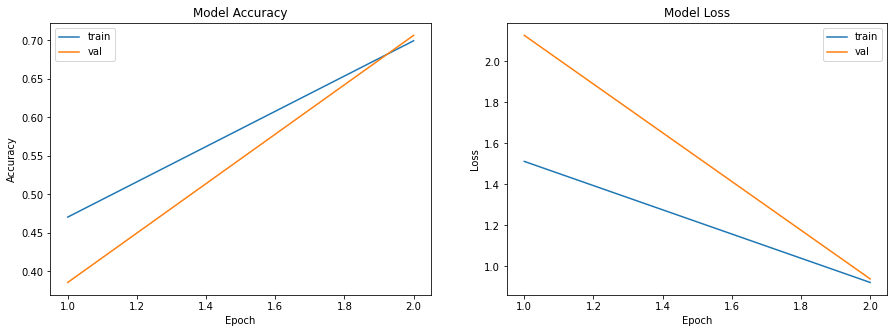

In [0]:
def plot_model_history(history):
    fig, axs = plt.subplots(1,2,figsize=(15,5))
    
    # summarize history for accuracy
    axs[0].plot(range(1,len(history.history['accuracy'])+1),history.history['accuracy'])
    axs[0].plot(range(1,len(history.history['val_accuracy'])+1),history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1,len(history.history['accuracy'])+1),len(history.history['accuracy'])/10)
    axs[0].legend(['train', 'val'], loc='best')
    
    # summarize history for loss
    axs[1].plot(range(1,len(history.history['loss'])+1), history.history['loss'])
    axs[1].plot(range(1,len(history.history['val_loss'])+1), history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1,len(history.history['loss'])+1),len(history.history['loss'])/10)
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()

# plot model history
plot_model_history(history)

# Download files and folders

In [0]:
!zip -r /content/logs_MBN.zip /content/logs

from google.colab import files
files.download("/content/logs_MBN.zip")

  adding: content/logs/ (stored 0%)
  adding: content/logs/fit/ (stored 0%)
  adding: content/logs/fit/MBN_S8/ (stored 0%)
  adding: content/logs/fit/MBN_S8/20200609-085831/ (stored 0%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/ (stored 0%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/ (stored 0%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/profile/ (stored 0%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/profile/2020_06_09_08_58_42/ (stored 0%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/profile/2020_06_09_08_58_42/351538f14724.overview_page.pb (deflated 59%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/profile/2020_06_09_08_58_42/351538f14724.input_pipeline.pb (deflated 57%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/profile/2020_06_09_08_58_42/351538f14724.kernel_stats.pb (deflated 96%)
  adding: content/logs/fit/MBN_S8/20200609-085831/train/plugins/pro

MessageError: ignored